In [1]:
import cv2
from skimage import color, morphology
import utils
from networkx import read_shp, DiGraph
import networkx as nx
import geopandas as gpd
from matplotlib import pyplot as plt

In [13]:
%%javascript 
IPython.OutputArea.prototype._should_scroll = function(lines) { return false; }

<IPython.core.display.Javascript object>

### Find skeleton of binary floorplan

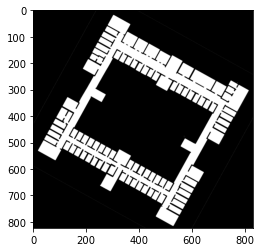

In [2]:
b2f3_outline = cv2.imread('Data\\UJI_B2F3_binary.jpg',0)
plt.imshow(b2f3_outline, cmap=plt.cm.gray)
plt.show()

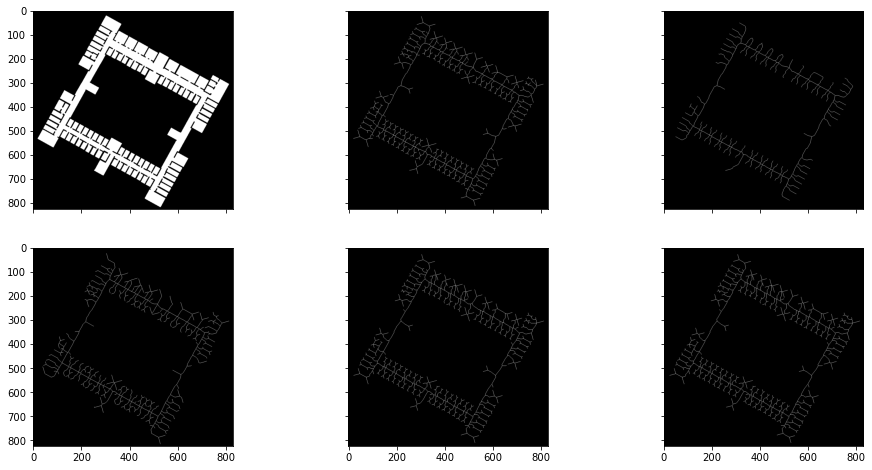

In [3]:
fig, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=True, sharey=True)
ax = axes.ravel()

bw_b2f3 = b2f3_outline > 195 * 1
ax[0].imshow(bw_b2f3, cmap=plt.cm.gray)

skel = morphology.skeletonize(bw_b2f3)
ax[1].imshow(skel, cmap=plt.cm.gray)

skel_lee = morphology.skeletonize(bw_b2f3, method='lee')
ax[2].imshow(skel_lee, cmap=plt.cm.gray)

axis, distance = morphology.medial_axis(bw_b2f3, return_distance=True)
ax[3].imshow(axis, cmap=plt.cm.gray)

thinned = morphology.thin(bw_b2f3)
ax[4].imshow(thinned, cmap=plt.cm.gray)

thinned_partial = morphology.thin(bw_b2f3, max_iter=30)
ax[5].imshow(thinned_partial, cmap=plt.cm.gray)

This skeleton is then used to create shapefile using Qgis, by tracing on the georeferenced skeleton image. 

### Create graph model

In [4]:
paths = read_shp("Outputs\\2\\UJI_B2F3_paths.shp", simplify=False).to_undirected()

In [14]:
rooms = gpd.read_file("Outputs\\2\\UJI_B2F3_rooms.shp")
rooms

,id,room_type,geometry
0,1,classroom,"POLYGON ((-7382.330 4864868.381, -7371.186 486..."
1,2,classroom,"POLYGON ((-7386.200 4864861.438, -7386.200 486..."
2,3,classroom,"POLYGON ((-7388.082 4864858.060, -7380.367 486..."
3,4,classroom,"POLYGON ((-7390.013 4864854.595, -7386.148 486..."
4,5,classroom,"POLYGON ((-7391.884 4864851.214, -7384.154 486..."
...,...,...,...
93,95,classroom,"POLYGON ((-7402.473 4864788.707, -7402.473 486..."
94,96,classroom,"POLYGON ((-7404.401 4864793.125, -7405.823 486..."
95,97,stairs,"POLYGON ((-7391.720 4864821.550, -7386.239 486..."
96,6,classroom,"POLYGON ((-7395.605 4864844.489, -7393.721 486..."


<AxesSubplot:>

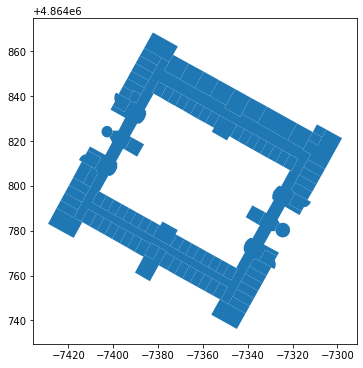

In [6]:
buffer = []
for room in rooms.geometry:
    room2 = room.buffer(0)
    buffer.append(room2)

gpd.GeoSeries(buffer).plot(figsize=(6,6))

#### Process and add useful data to edges

- id: a unique identifier
- length: spatial length of the edge in meters
- isEntrance: if the edge is a path to another floor
- isDoorway: if the edge is a path to another room 

In [8]:
# retrieve room id of entrances to floor
st_ids_arr = rooms[rooms['room_type'].isin(['lift','stairs'])]['id'].unique()

eid = 0
to_remove = []
for u, v, data in paths.edges(data=True):
    paths[u][v]['id'] = eid
    paths[u][v]['length'] = utils.geodesic_distance(u, v, is_3857=True) 
    paths[u][v]['isEntrance'] = data['room_id'] in st_ids_arr
    if paths[u][v]['length'] < 0.000001:
        # remove edge from model
        to_remove.append((u,v))
    else:
        eid += 1

for r in to_remove:
    paths.remove_edge(r[0], r[1])

In [18]:
isDoorDict = {}
for n in paths.nodes():
    adjacent_edges = paths.edges([n], data=True)
    room_ids = [e[2]['room_id'] for e in adjacent_edges]
    room_ids = list(set(room_ids))
    isDoorDict[n] = {'isDoorway': len(room_ids) > 1}

nx.set_node_attributes(paths, isDoorDict)

#### Visualize Graph Model

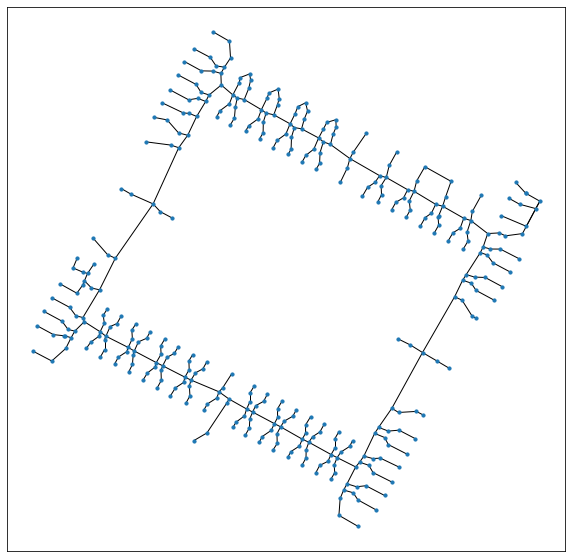

In [16]:
plt.figure(figsize=(10,10))
nx.draw_networkx_nodes(paths, {n: n for n in paths}, node_size=10)
nx.draw_networkx_edges(paths, {n: n for n in paths}, width=1)
plt.show()

#### Write to output file to store the graph model

In [12]:
nx.write_shp(paths, "Outputs\\2\\Graph Model") 